## Описание модели 

В качестве модели было решено использовать рекуррентную сеть с LSTM слоем, после него линейный слой с двумя выходами. Главное преимущество такой архитектуры, что она не большая, но при этом способна выдавать метрики качества выше, чем классические методы. 

        Model parameters: 8522
        Net:
          ReLU()
          LSTM(24, 30)
          Linear(out_features=2)
          Softmax()
        

* Задача  VAD  является  задачей бинарной классификации, поэтому можно спокойно использовать в качестве лосса cross-entropy 

* Метрика качества - accuracy

## Результаты

Модель имеет хорошую предсказательную способность. Ниже приведены метрики качества, а также графики обучения и ROC AUC

    Train acc: 0.9369044899940491
    Val acc: 0.9371353387832642
Сравнение Accuracy с моделью WebrtcVAD при разных уровнях sensitivity:

    Accuracy (sensitivity 0): 0.58062518364119
    Accuracy (sensitivity 1): 0.625073302960146
    Accuracy (sensitivity 2): 0.6823060436137106

<img src="4.png">

* ROC AUC полученной модели 

<img src="1.png" width="600">

* Расчет метрик FA, FR, EER реализован в функции far и function_det:


        FA: 68.93% при FR = 1.03%
        FR: 16.64% при FA = 1.10%
        EER: ~7%  (FA= 7.63%  FR=7.02%)
 
* Сравнение с моделью WebrtcVAD при разных уровнях чувствительности 

    Accuracy (sensitivity 0): 0.58062518364119
    Accuracy (sensitivity 1): 0.625073302960146
    Accuracy (sensitivity 2): 0.6823060436137106
    
Пример предсказания разметки с помощью WebrtcVAD: на последних 2ух секундах модель предсказала лейбл 1, хотя на самом деле там просто шум. Пример аудиозапси можно прослушать ниже.

<img src="3.png">


## Гипотезы по улучшению 

1. Добавление Attention слоя позволит сделать модель более устойчивой к шуму и не особо утяжелит ее
2. Ради эксперимента попробовать обучить модель с архитектурой CNN-BiLSTM, то есть реализовать [статью](https://arxiv.org/pdf/2103.03529.pdf)
3. Использование различных уровней шума. То есть добавить больше аугментированных данных. Это сделает модель более устойчивой
4. Возможно использование Focal Loss вместо Cross Entropy немного улучшит результаты. 

In [1]:
import os
path_peer = 'LibriSpeech/'
is_peer = os.path.exists(path_peer)

if is_peer:
    os.chdir(path_peer)

print('Directory is set to', os.getcwd())

Directory is set to /home/eva/eva_project_dir/VAD/LibriSpeech


In [2]:
import pandas as pd
import numpy as np
import array

import sys

import librosa
import librosa.display
import matplotlib.pyplot as plt

from function import * 
from function_viz import * 
from function_det import * 

from IPython.display import Audio
from IPython.display import clear_output

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
import glob
import re
from pydub import AudioSegment
import soundfile as sf
import h5py
import h5py_cache
import webrtcvad
import python_speech_features


In [4]:
import torch

import torch.nn as nn
from torch.nn import Linear, RNN, LSTM, GRU
import torch.nn.functional as F
from torch.nn.functional import softmax, relu
from torch.autograd import Variable


import torch.optim as optim
import time

from sklearn.metrics import confusion_matrix
import math


from sklearn import metrics

In [5]:
OBJ_CUDA = torch.cuda.is_available()

In [6]:
SAMPLE_RATE = 16000
SAMPLE_CHANNELS = 1
SAMPLE_WIDTH = 2

BATCH_SIZE = 2048
FRAMES = 30
FEATURES = 24
STEP_SIZE = 6

In [7]:
data = h5py.File('features.hdf5', 'r+')
noise_levels_db = {'-3': -3 }

In [8]:
def set_seed(seed = 77):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [9]:
class DataGenerator:
    
    def __init__(self, data, size_limit=0):        
        self.data = data
        self.size = size_limit if size_limit > 0 else len(data['labels'])
        self.data_mode = 0 
    
    #функция необходима, если нужно провести несколько экспериментов с разным
    #уровнем шума. В ходе данной работы был использован только один уровень шума
    def set_noise_level_db(self, level, reset_data_mode = True):
            
        self.noise_level = level
        
        
        if reset_data_mode:
            if self.data_mode == 0:
                self.use_train_data()
            elif self.data_mode == 1:
                self.use_validate_data()
            elif self.data_mode == 2:
                self.use_test_data()
    #Разбиваем данные на 80% трейн, 10% валидация, 10% тест    
    def setup_generation(self, frame_count, step_size, batch_size, val_part=0.1, test_part=0.1):
        
        self.frame_count = frame_count
        self.step_size = step_size
        self.batch_size = batch_size
        
        # Получаем индексы и размеры для обучения, теста и валидации        
        self.train_index = 0
        self.val_index = int((1.0 - val_part - test_part) * self.size)
        self.test_index = int((1.0 - test_part) * self.size)
        
        self.train_size = self.val_index
        self.val_size = self.test_index - self.val_index
        self.test_size = self.size - self.test_index
        
    def use_train_data(self):
        
        # Расчитываем кол-во батчей, которое нужно получить исходя из заданных параметров
        n = int((self.train_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.train_index
        self.data_mode = 0
        
    def use_validate_data(self):
        
        # Аналогично предыдущему, но для валидации
        n = int((self.val_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.val_index
        self.data_mode = 1
        
    def use_test_data(self):
        # Аналогично предыдущему, но для теста
        n = int((self.test_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.test_index
        self.data_mode = 2

    def get_data(self, index_from, index_to):
        frames = self.data['frames-' + self.noise_level][index_from : index_to]
        mfcc = self.data['mfcc-' + self.noise_level][index_from : index_to]
        delta = self.data['delta-' + self.noise_level][index_from : index_to]
        labels = self.data['labels'][index_from : index_to]
        return frames, mfcc, delta, labels
        
    def get_batch(self, index):        
        # Текущая позиция
        pos = self.initial_pos + (self.batch_size * index) * self.step_size
        
        # Получаем все необходимые данные
        l = self.frame_count + self.step_size * self.batch_size
        frames, mfcc, delta, labels = self.get_data(pos, pos + l)
        
        x, y, i = [], [], 0
        
        
        while len(y) < self.batch_size:            
            
            #получаем вектор фичей
            X = np.hstack((mfcc[i : i + self.frame_count], delta[i : i + self.frame_count]))
            
            # Сохраняем в лист фреймов 
            x.append(X)
            
            # Выбираем лейбл из середины последовательности 
            y_range = labels[i : i + self.frame_count]
            y.append(int(y_range[int(self.frame_count / 2)]))           
            
            i += self.step_size
        
        return x, y
        
    def plot_data(self, index_from, index_to, show_track=False):
        
        frames, mfcc, delta, labels = self.get_data(index_from, index_to)
        
        Vis.plot_sample(frames, labels)
        Vis.plot_sample_webrtc(frames)
        
        
        #вывод аудиодоржки
        if show_track:
            return (AudioSegment(data=array.array('h', frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
        


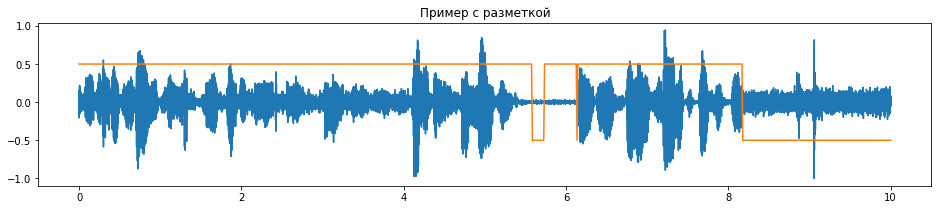

80 % voice 20 % silence


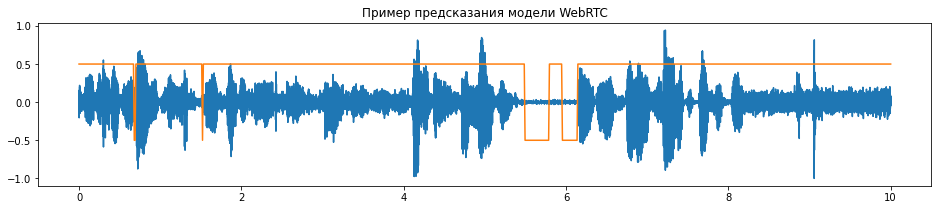

In [10]:
# Проверим на одном примере из датасета
generator = DataGenerator(data, size_limit=10000)

generator.setup_generation(frame_count=3, step_size=1, batch_size=2)
generator.set_noise_level_db('-3')
generator.use_train_data()
X, y = generator.get_batch(0)



generator.plot_data(0, 1000, show_track = True)

In [11]:
def num_params(net, verbose = True):
    count = sum(p.numel() for p in net.parameters())
    if verbose:
        print(f'Model parameters: {count}')
    return count

In [12]:
def accuracy(out, y):    
    #out.shape = (64, 2) and y.shape = (64)
    
    out = torch.max(out, 1)[1].float()
    eq = torch.eq(out, y.float()).float()
    return torch.mean(eq)

## Архитектура предложенной модели

In [13]:
class Net(nn.Module):
    
    def __init__(self,lstm = True):
        super(Net, self).__init__()
    
        
        self.lstm = lstm
        self.relu = nn.ReLU()       
        
        self.hidden = self.init_hidden()
        self.rnn = LSTM(input_size=FEATURES, hidden_size=FRAMES, num_layers=1, batch_first=True)
      
        self.lin = nn.Linear(FRAMES**2, 2)
            
        self.softmax = nn.Softmax(dim=1)
    
    def init_hidden(self):
        h = Variable(torch.zeros(1, BATCH_SIZE, FRAMES))
        c = Variable(torch.zeros(1, BATCH_SIZE, FRAMES))        
        
        h = h.cuda()
        c = c.cuda()
        
        return h, c
    
    def forward(self, x):
       
        x, _ = self.rnn(x, self.hidden)
            
        x = x.contiguous().view(-1, FRAMES**2)
        x = self.lin(x)
        
        return self.softmax(x)

net = Net()
num_params(net)
print(net)

Model parameters: 8522
Net(
  (relu): ReLU()
  (rnn): LSTM(24, 30, batch_first=True)
  (lin): Linear(in_features=900, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


In [14]:
NOISE_LEVELS = ['-3']

def net_path(epoch, title):
    part = os.getcwd() + '/models/' + title
    if epoch >= 0:
        return part + '_epoch' + str(epoch).zfill(3) + '.net'
    else:
        return part + '.net'

def save_net(net, epoch, title = 'net'):
    if not os.path.exists(os.getcwd() + '/models'):
        os.makedirs(os.getcwd() + '/models')
    torch.save(net, net_path(epoch, title))
    
def load_net(epoch = 14, title = 'net'):
    return torch.load(net_path(epoch, title))
    

def train_net(net, data, size_limit = 0, noise_level = '-3', epochs = 15, lr = 1e-3, use_adam = True,
              weight_decay = 1e-5, momentum = 0.9, use_focal_loss = False, gamma = 0.0,
              early_stopping = False, patience = 25, frame_count = FRAMES, step_size = STEP_SIZE,
              auto_save = True, title = 'net', verbose = True, verbose_plot=True):
   
    
   
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(frame_count, step_size, BATCH_SIZE)   
    
    net.cuda()        
    criterion = nn.CrossEntropyLoss()
    criterion.cuda()
    levels = [noise_level]    
    
       
    if use_adam:
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    #
    if verbose:
        print(OBJ_CUDA)
        print(f'Initiating training of {title}...\n\nLearning rate: {lr}')
        _trsz = generator.train_size*3 if use_focal_loss else generator.train_size
        _vlsz = generator.val_size*3 if use_focal_loss else generator.val_size
        print(f'Model parameters: {sum(p.numel() for p in net.parameters())}')
        print(f'Frame partitions: {_trsz} | {_vlsz}')
        _critstr = f'Focal Loss (γ = {gamma})' if use_focal_loss else f'Cross-Entropy ({noise_level} dB)'
        _optmstr = f'Adam (decay = {weight_decay})' if use_adam else f'SGD (momentum = {momentum})'
        _earlstr = f'Early Stopping (patience = {patience})' if early_stopping else str(epochs)
        _autostr = 'Enabled' if auto_save else 'DISABLED'
        print(f'Criterion: {_critstr}\nOptimizer: {_optmstr}')
        print(f'Max epochs: {_earlstr}\nAuto-save: {_autostr}')
    
    net.train()
    stalecount, maxacc = 0, 0
    
    def plot(losses, accs, val_losses, val_accs):
        #Вывод графиков на каждой эпохе
        e = [i for i in range(len(losses))]
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(e, losses, label='Loss (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_losses, label='Loss (Validation)')
            
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(e, accs, label='Accuracy (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_accs, label='Accuracy (Validation)')
            
        plt.legend()
        plt.show()
        clear_output(wait=True)
    # Переменная  optimize = True для обратного распр ошибики и обучения весов   
    def run(net, optimize = False):
       
        epoch_loss, epoch_acc, level_acc = 0, [], []        
      
        batches = generator.batch_count
        num_batches = batches*len(levels)        
        
        # Функиция для расчета батча
        def run_batch(X, y, epoch_loss, epoch_acc):

            X = Variable(torch.from_numpy(np.array(X)).float())
            y = Variable(torch.from_numpy(np.array(y))).long()

           
            X = X.cuda()
            y = y.cuda()
            out = net(X)

            # Расчитываем метрики для батча
            batch_loss = criterion(out, y)
            batch_acc = accuracy(out, y)

            # Для обучения инициализируем опбратную распр ошибки 
            if optimize == True:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

           
            batch_acc = batch_acc.cpu()
            batch_loss = batch_loss.cpu()
            
            epoch_loss += batch_loss.data.numpy() / float(BATCH_SIZE)
            epoch_acc.append(batch_acc.data.numpy())

            return epoch_loss, epoch_acc
        
        # Для экспериментов с шумом итерируемся по уровням шума        
        for lvl in levels:
            
            # Генератор для итериаций
            generator.set_noise_level_db(lvl)
            
            # Для каждого батча для каждого уровня шума
            for i in range(batches):
                #создаем новый батч и расчитываем новые метрики
                X, y = generator.get_batch(i)
                temp_loss, temp_acc = run_batch(X, y, epoch_loss, epoch_acc)
                epoch_loss += temp_loss / float(num_batches)
                level_acc.append(np.mean(temp_acc))

        return epoch_loss, np.mean(level_acc)
    
    #создаем списки для метрик
    losses, accs, val_losses, val_accs = [], [], [], []
    
    if verbose:
        start_time = time.time()
    
    # Итерация по эпохам во время обучения
    for epoch in range(epochs):
        
        # Считаем loss и accs для эпохи
        generator.use_train_data()
        loss, acc = run(net, optimize=True)
        print('Train loss: {}, Train acc: {}'.format(loss, acc))
        losses.append(loss)
        accs.append(acc)
        
        # расчитываем метрики на валидации
        if generator.val_size != 0:
            net.eval()
            generator.use_validate_data()
            val_loss, val_acc = run(net)
            print('Val loss: {}, Val acc: {}'.format(val_loss, val_acc))
                       
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            net.train()
            
     
            # Если accuracy на валидации не меняется в течении нескольоких эпох,
            # то обучение останавливается и возвращается луччшая модель, у которой лучшая accuracy на валидации        
            if epoch > 0 and val_accs[-1] <= maxacc:
                stalecount += 1
                if stalecount > patience and early_stopping:
                    return
            else:
                stalecount = 0
                maxacc = val_accs[-1]
        
        if auto_save:
            save_net(net, epoch, title)
        
        # Oрисовка метрик во время обучения
        if verbose_plot:
            
            # Print measured wall-time of first epoch
            if epoch == 0:
                dur = str(int((time.time() - start_time)/60))
                print(f'\nEpoch wall-time: {dur} min')
                
            plot(losses, accs, val_losses, val_accs)


In [15]:
def test_predict(net, data, size_limit, noise_level):
   
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)    
     
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    y_true, y_score = [], []

    for i in range(generator.batch_count):

        X, y = generator.get_batch(i)
        X = Variable(torch.from_numpy(np.array(X)).float())
        y = Variable(torch.from_numpy(np.array(y))).long()

       
        X = X.cuda()
        out = net(X) 
        
        out = out.cpu()        
        y = y.cpu()

        # Добавляем true labels.
        y_true.extend(y.data.numpy())

        # Добавляем предсказанные вероятности
        y_score.extend(out.data.numpy()[:,1])
    
    return y_true, y_score


def roc_auc(nets, data, noise_lvl, size_limit = 0):

    plt.figure(1, figsize=(16, 10))
    plt.title('ROC AUC' , fontsize = 16)
        
    for key in nets:
        
        net = nets[key]  
        
        y_true, y_score = test_predict(net, data, size_limit, noise_lvl)
       
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
        auc_res = metrics.auc(fpr, tpr)        
        plt.plot(fpr, tpr, label='%s (AUC = %0.3f)' % (key, auc_res))

    plt.xlim([0, 0.2])
    plt.ylim([0.6, 1])
    plt.ylabel('True Positive Rate', fontsize = 16)
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right', prop={'size': 16})
    plt.show()

### Расчет метрик FA, FF, EER

In [35]:
def far(net, data, size_limit = 0, frr = 1, far=1, plot = True):
    
    # 1.Расчитываем конфьюжн матрицу
    # 2.Считаем tn, fp, fn, tp 
    # 3.По ним на каждом threshold вычисляем far, frr
    # 4.Возвращаем нужные значения в зависимости от условий на far, frr 
    
    # В зависимости от трешхолда вычисляем предскзания по классам
    def apply_threshold(y_score, t = 0.5):
        return [1 if y >= t else 0 for idx, y in enumerate(y_score)]
    
    def fix_frr(y_true, y_score, frr_target):        
        t = 1e-9        
        # Расчитывваем FAR для FRR = 1%
        while t < 1.0:            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            if frr >= frr_target:
                return far, frr, t
            
            t *= 1.1       
        return far, frr, t
    
    def fix_far(y_true, y_score, far_target):       
        t = 1.2
        
        # Расчитывваем FRR для FAR = 1%
        while t > 0:
            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            if int(far) >= far_target:
                return frr, far, t
            
            t *= 0.999      
        

    def fix_eer(y_true, y_score):       
        t = 1e-9
        
        # Расчитываем FRR для FAR = 1%
        while t < 1.0:
            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            if int(far) == int(frr):
                return far, frr, t
            
            t *= 1.1       
        

    print('Network metrics:')
    
    for lvl in NOISE_LEVELS:        
        
        y_true, y_score = test_predict(net, data, size_limit, lvl)
        
        print('FA: %0.2f%% for fixed FR at %0.2f%%, tr %0.2f%%' % fix_frr(y_true, y_score, frr))
        print('FR: %0.2f%% for fixed FA at %0.2f%%, tr %0.2f%%' % fix_far(y_true, y_score, far))
        print('EER: %0.2f%% for FA = FR=%0.2f%%, tr %0.2f%%' % fix_eer(y_true, y_score))


In [17]:
def netvad(net, data, noise_level = '-3', init_pos = 50, length = 700, only_plot_net = False, timeit = True):
    '''
    Generates a sample of specified length and runs it through
    the given network. By default, the network output is plotted
    alongside the original labels and WebRTC output for comparison.
    '''
    
    # Set up an instance of data generator using default partitions
    generator = DataGenerator(data)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    raw_frames, mfcc, delta, labels = generator.get_data(init_pos, init_pos+length)

    # Convert sample to list of frames
    def get_frames():
        i = 0
        while i < length-FRAMES:
            yield np.hstack((mfcc[i : i + FRAMES], delta[i : i + FRAMES]))
            i += 1
        
    # Start timer
    if timeit:
        start_net = time.time()
        
    # Создаем батч из фреймов
    frames = list(get_frames())
    batches, i, num_frames = [], 0, -1
    while i < len(frames):
        full = i+BATCH_SIZE >= len(frames)
        end = i+BATCH_SIZE if not full else len(frames)
        window = frames[i:end]
        if full:
            num_frames = len(window)
            while len(window) < BATCH_SIZE:
                window.append(np.zeros((FRAMES, FEATURES)))
        batches.append(np.stack(window))
        i += BATCH_SIZE
        
    # Предсказание для каждого фрейма
    offset = 15
    accum_out = [0] * offset
    for batch in batches:
        X = Variable(torch.from_numpy(batch).float())
        if OBJ_CUDA:
            out = torch.max(net(X.cuda()), 1)[1].cpu().float().data.numpy()
        else:
            out = torch.max(net(X), 1)[1].float().data.numpy()
        accum_out.extend(out)
        
    
    if timeit:
        dur_net = str((time.time() - start_net)*1000).split('.')[0]
        device = 'GPU' if OBJ_CUDA else 'CPU'
        seq_dur = int((length/100)*3)
        print(f'Network processed {len(batches)*BATCH_SIZE} frames ({seq_dur}s) in {dur_net}ms on {device}.')

    # padding
    if num_frames > 0:
        accum_out = accum_out[:len(accum_out)-(BATCH_SIZE-num_frames)]
    accum_out = np.array(accum_out)
    
    frames = np.array(frames)
    
    # Отрезаем фреймы вне предсказания
    raw_frames = raw_frames[offset:-offset]
    labels = labels[offset:-offset]
    accum_out = accum_out[offset:]

    # Вывод результатов
    print('Displaying results for noise level:', noise_level)
    if not only_plot_net:
        Vis.plot_sample(raw_frames, labels, show_distribution = False)
        Vis.plot_sample_webrtc(raw_frames, sensitivity = 0)
    Vis.plot_sample(raw_frames, accum_out, title = 'Sample (Neural Net)', show_distribution = False)


Train loss: 0.0003143466898462542, Train acc: 0.9369044899940491
Val loss: 0.0003141095526711414, Val acc: 0.9371353387832642


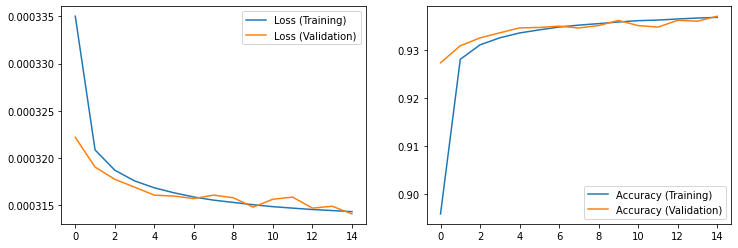

In [18]:
set_seed()
net = Net()
train_net(net, data, title='net', gamma=0)

In [ ]:
far(net, data, frr=1, far = 1)

Network metrics:


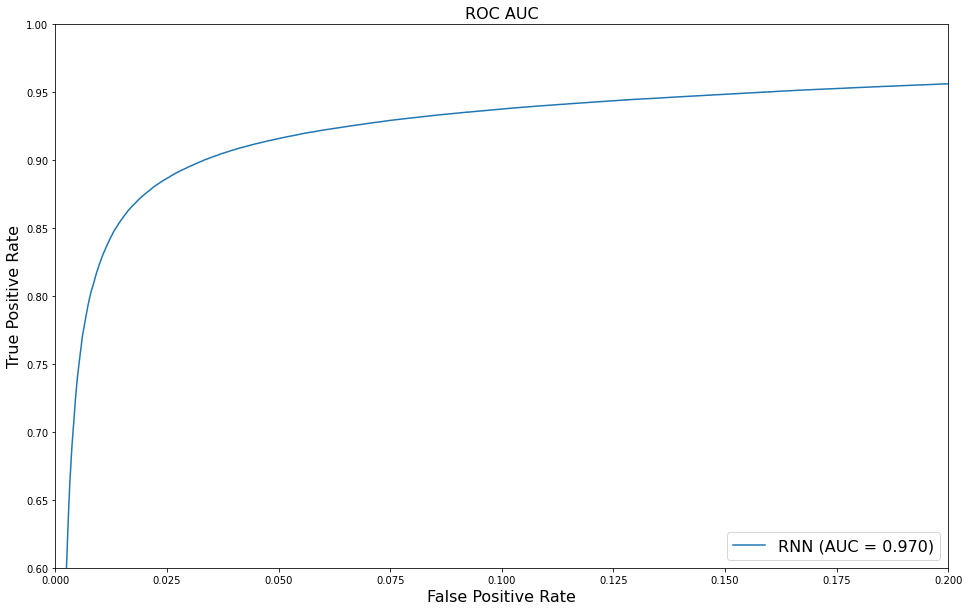

In [20]:
roc_auc({
    'RNN': net, 
}, data, '-3')



net:
Network processed 2048 frames (21s) in 142ms on GPU.
Displaying results for noise level: -3


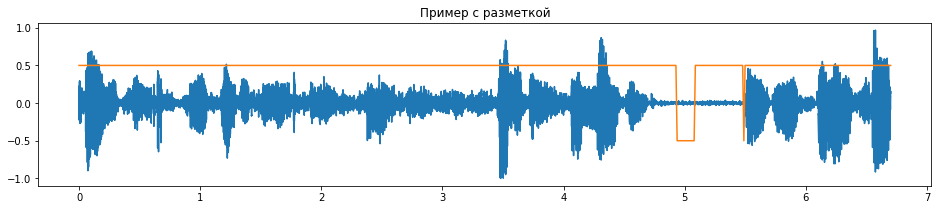

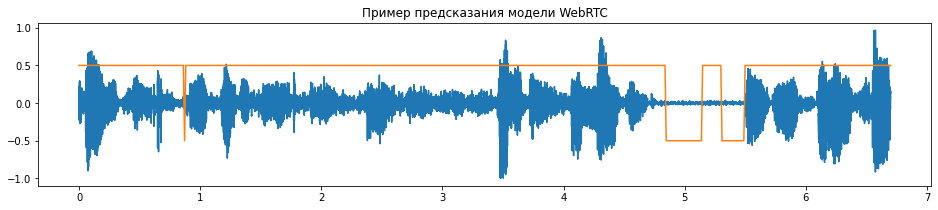

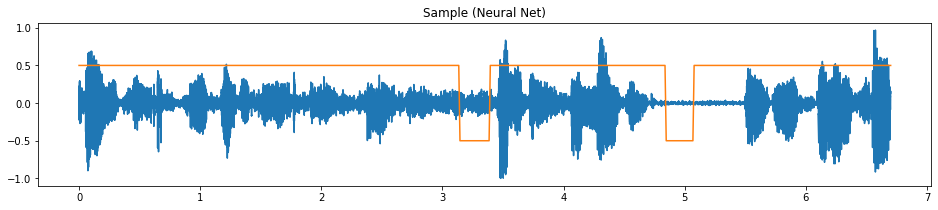

In [21]:
print('\nnet:')
netvad(net, data, only_plot_net=False)

In [22]:
def webrtc_vad_accuracy(data, sensitivity, noise_level):

    vad = webrtcvad.Vad(sensitivity)    
    generator = DataGenerator(data, size_limit=0)   
    
    generator.setup_generation(frame_count=1, step_size=1, batch_size=1)   
    
    generator.set_noise_level_db(noise_level)
    generator.use_test_data()
    
    correct = 0
    batch_size = 1000
    
    for pos in range(0, generator.size, batch_size):
        
        frames, _, _, labels = generator.get_data(pos, pos + batch_size)
        
        for i, frame in enumerate(frames):
            if vad.is_speech(frame.tobytes(), sample_rate=SAMPLE_RATE) == labels[i]:
                correct += 1

    return (correct / generator.size)


print('Accuracy (sensitivity 0):', webrtc_vad_accuracy(data, 0, '-3'))


print('Accuracy (sensitivity 1):', webrtc_vad_accuracy(data, 1, '-3'))


print('Accuracy (sensitivity 2):', webrtc_vad_accuracy(data, 2, '-3'))


Accuracy (sensitivity 0): 0.58062518364119
Accuracy (sensitivity 1): 0.625073302960146
Accuracy (sensitivity 2): 0.6823060436137106
